In [1]:
from ROOT import TMVA, TFile, TTree, TCut, TString
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Concatenate, Dense, LSTM, Input, concatenate, SimpleRNN, GRU, Masking, Lambda, Reshape, Dropout, RNN
from tensorflow.keras.optimizers import Adagrad, SGD, RMSprop, Adam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from IPython.display import display
import graphviz
from numba import cuda
from array import array
import pickle
import scikitplot as skplt
import seaborn as sns

Welcome to JupyROOT 6.19/01


Load signal and background trees

In [2]:
signalFile=TFile.Open("samples/sig_nonres_bbtt.root")
backgroundFile=TFile.Open("samples/bkg_ttbar_dilepton.root")

In [3]:
signalTree=signalFile.Get("ntup")
backgroundTree=backgroundFile.Get("ntup")

In [4]:
signalNum=signalTree.GetEntries()
backgroundNum=backgroundTree.GetEntries()
print("signal events number before cut is: ",signalNum)
print("background events number before cut is: ",backgroundNum)

signal events number before cut is:  217248
background events number before cut is:  10995


Convert minitree into numpy

In [5]:
signalArray=signalTree.AsMatrix(["weight","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
backgroundArray=backgroundTree.AsMatrix(["weight","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
print(signalArray.shape)

(217248, 22)


In [6]:
dataSignal=pd.DataFrame(data=signalArray[:,1:],columns=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])

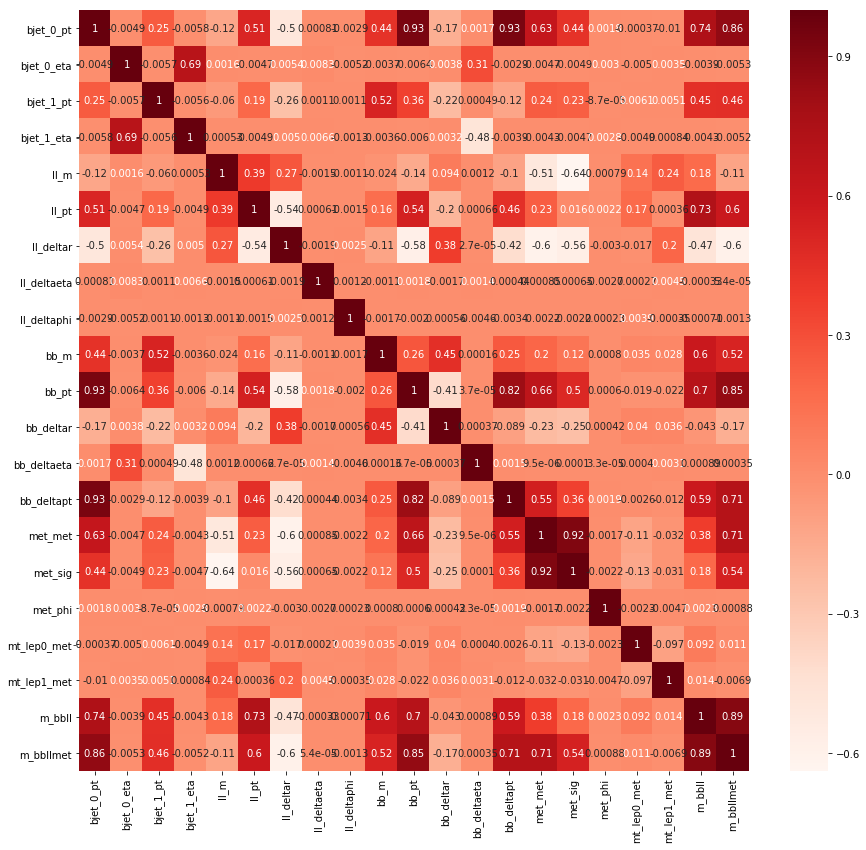

In [7]:
plt.figure(figsize=(15,14))
cor = dataSignal.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

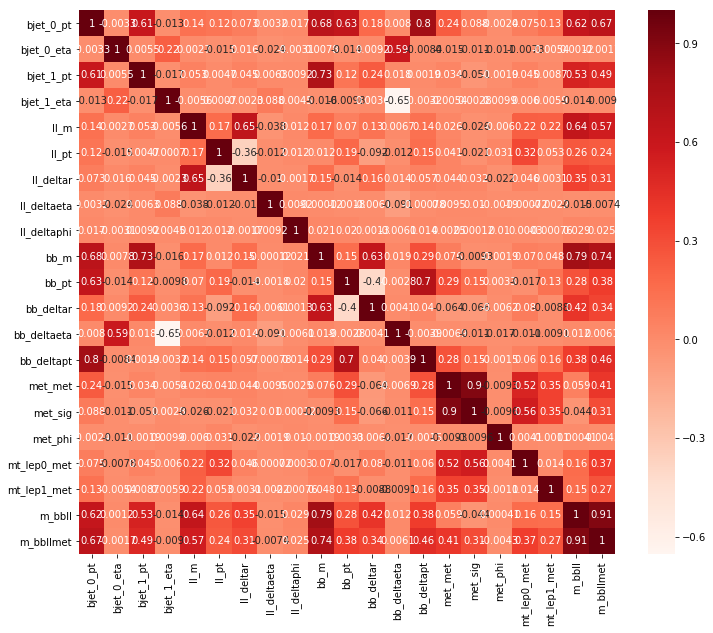

In [8]:
dataBackground=pd.DataFrame(data=backgroundArray[:,1:],columns=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
plt.figure(figsize=(12,10))
cor = dataBackground.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()



In [9]:
print(signalArray)

[[ 5.99125689e-08  3.43779406e+05 -8.89795244e-01 ...  8.16832910e+03
   1.01459575e+06  1.15864900e+06]
 [ 1.37623146e-05  2.02115812e+05 -1.13858283e+00 ...  4.82755898e+04
   4.13342219e+05  5.49812625e+05]
 [ 1.21445784e-06  2.04746391e+05  1.65332592e+00 ...  2.39445947e+03
   4.90221562e+05  9.90220812e+05]
 ...
 [ 3.69084698e-05  9.59073438e+04 -1.60544014e+00 ...  1.28037285e+04
   2.70796531e+05  3.64658312e+05]
 [ 4.55069750e-06  2.05500875e+05  5.38439453e-01 ...  1.36688916e+04
   5.46038250e+05  6.63057375e+05]
 [ 1.65528623e-06  2.39564734e+05 -1.39261913e+00 ...  3.73748608e+03
   4.83871188e+05  1.09625988e+06]]


In [10]:
print(signalArray[:,1])

[343779.40625  202115.8125   204746.390625 ...  95907.34375  205500.875
 239564.734375]


Add signal Region cuts $m_{jj}>300$ Gev and $|\Delta(y_{jj})|>2.0$.

In [11]:
signalSample=signalArray#[(abs(signalArray[:,3])>2.0)&(signalArray[:,1]>300)]
backgroundSample=backgroundArray#[(abs(backgroundArray[:,3])>2.0)&(backgroundArray[:,1]>300)]

In [12]:
print(len(signalSample))
print(len(backgroundSample))

217248
10995


In [13]:
signalNum=len(signalSample)
backgroundNum=len(backgroundSample)
print("signal event number after cut is: ",signalNum)
print("background event number after cut is:",backgroundNum)

signal event number after cut is:  217248
background event number after cut is: 10995


Split datasets into training and testing subsets

In [14]:
trainingRatio=0.9
sigTrainNum=int(signalNum*0.9)
backgroundTrainNum=int(backgroundNum*0.9)
sigTestNum=signalNum-sigTrainNum
backgroundTestNum=backgroundNum-backgroundTrainNum
print("training signal events number is: ",sigTrainNum)
print("testing signal events number is: ",sigTestNum)
print("training background events number is: ",backgroundTrainNum)
print("testing background events number is: ",backgroundTestNum)


training signal events number is:  195523
testing signal events number is:  21725
training background events number is:  9895
testing background events number is:  1100


In [15]:
signal_row=np.arange(0,signalNum-1,1)
background_row=np.arange(0,backgroundNum-1,1)
signal_train_row=np.random.choice(signal_row,size=sigTrainNum,replace=False)
background_train_row=np.random.choice(background_row,size=backgroundTrainNum,replace=False)
label_signal_train=np.ones((sigTrainNum,1))
label_background_train=np.zeros((backgroundTrainNum,1))
label_signal_test=np.ones((sigTestNum,1))
label_background_test=np.zeros((backgroundTestNum,1))
signalTrain=signalSample[signal_train_row,:]
signalTest=np.delete(signalSample,signal_train_row,axis=0)
backgroundTrain=backgroundSample[background_train_row,:]
backgroundTest=np.delete(backgroundSample,background_train_row,axis=0)
signalTrain=np.concatenate((label_signal_train,signalTrain),axis=1)
backgroundTrain=np.concatenate((label_background_train,backgroundTrain),axis=1)
signalTest=np.concatenate((label_signal_test,signalTest),axis=1)
backgroundTest=np.concatenate((label_background_test,backgroundTest),axis=1)
ratio=sum(signalTrain[:,1])/sum(backgroundTrain[:,1])
signalTrain[:,1]=signalTrain[:,1]/ratio
print(backgroundTest)
print(ratio)

[[0.00000000e+00 2.82344468e-02 1.82759812e+05 ... 8.01081016e+04
  3.60351188e+05 5.71985250e+05]
 [0.00000000e+00 2.54102106e-02 8.72947578e+04 ... 4.83920078e+04
  3.08314594e+05 3.95065875e+05]
 [0.00000000e+00 2.67240324e-02 1.14289945e+05 ... 2.79315020e+04
  3.44851594e+05 3.59601531e+05]
 ...
 [0.00000000e+00 3.79247846e-02 2.72320664e+04 ... 1.88067754e+04
  2.09093422e+05 2.31133000e+05]
 [0.00000000e+00 4.91732780e-02 1.24339773e+05 ... 6.22692422e+04
  3.72589656e+05 5.49051375e+05]
 [0.00000000e+00 4.76664438e-02 1.04544781e+05 ... 8.39545000e+04
  2.79220312e+05 3.78958656e+05]]
0.0018122778850934152


In [16]:
dataTrain=np.vstack((signalTrain,backgroundTrain))
dataTest=np.vstack((signalTest,backgroundTest))
np.random.shuffle(dataTrain)
np.random.shuffle(dataTest)
dataTrainLabel=dataTrain[:,0]
dataTrainWeight=dataTrain[:,1]
dataTrainSample=dataTrain[:,2:]
dataTestLabel=dataTest[:,0]
dataTestWeight=dataTest[:,1]
dataTestSample=dataTest[:,2:]
tf.cast(dataTrainLabel,tf.float32)
tf.cast(dataTrainSample,tf.float32)

<tf.Tensor 'Cast_1:0' shape=(205418, 21) dtype=float32>

Signal and background training sets should have same yield in training

(205418,)
(205418,)


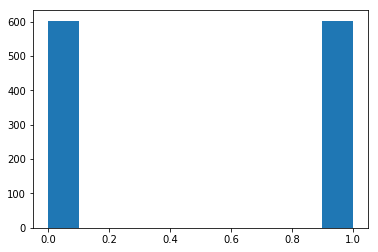

In [22]:
plt.hist(dataTrain[:,0],weights=dataTrainWeight)
print(dataTrainWeight.shape)
dataTrainWeight=dataTrainWeight.transpose()
print(dataTrainWeight.shape)
classweight = {0: 19.75,
                1: 1.}

Build model

In [33]:
model = Sequential()
model.add(Dense(300, kernel_initializer="random_normal", activation="relu",
    input_dim=21))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(1, kernel_initializer="random_uniform", activation="sigmoid"))

# Set loss, optimizer and evaluation metrics
model.compile(
     loss="binary_crossentropy",
     optimizer="adam",
     metrics=["binary_accuracy"])

In [34]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='acc',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')

In [35]:
model.save('model_HHZZ.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 300)               6600      
_________________________________________________________________
dense_12 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 301       
Total params: 97,201
Trainable params: 97,201
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.fit(dataTrainSample,dataTrainLabel,batch_size=50, epochs=30,
          sample_weight=dataTrainWeight,
          callbacks=[early_stopping])

Epoch 1/30
205418/205418 [==============================] - 13s 61us/sample - loss: 8.7568 - binary_accuracy: 0.0482
Epoch 2/30
130400/205418 [==================>...........] - ETA: 4s - loss: 8.9741 - binary_accuracy: 0.0485

KeyboardInterrupt: 

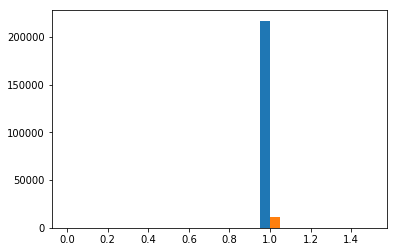

In [28]:
signalNN=model.predict(signalSample[:,1:])
backgroundNN=model.predict(backgroundSample[:,1:])
plt.hist(signalNN,bins=20)
plt.hist(backgroundNN,bins=20)
NNTrainScore=model.predict(dataTrainSample)

In [ ]:
backgroundNN=model.predict(backgroundSample[:,1:])
plt.hist(backgroundNN,bins=20)

Save NN model to h5 file

In [ ]:
model.save('model_4lNN.h5')
model.summary()

In [ ]:
signalNNScore=model.predict(signalArray[:,1:])
backgroundNNScore=model.predict(backgroundArray[:,1:])
print(signalNNScore)

In [ ]:
plt.hist(signalNNScore,bins=20)

In [37]:
cuda.select_device(0)
cuda.close()

In [38]:
BDTtrain=xgb.DMatrix(dataTrainSample,label=dataTrainLabel,weight=dataTrainWeight)
BDTtest=xgb.DMatrix(dataTestSample,label=dataTestLabel,weight=dataTestWeight)
BDTSignal=xgb.DMatrix(signalArray[:,1:])
BDTBackground=xgb.DMatrix(backgroundArray[:,1:])
param = {'max_depth': 6, 'eta': 0.6, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 16
param['eval_metric'] = 'auc'
param['tree_method'] = 'gpu_hist'
param['grow_policy'] = 'depthwise'
param['subsample']=0.9
evallist = [(BDTtest, 'eval'), (BDTtrain, 'train')]

/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndar

In [39]:
num_round = 500
GBDT = xgb.train(param, BDTtrain, num_round, evallist)

[0]	eval-auc:0.949806	train-auc:0.95929
[1]	eval-auc:0.973913	train-auc:0.974621
[2]	eval-auc:0.978148	train-auc:0.980814
[3]	eval-auc:0.983154	train-auc:0.983103
[4]	eval-auc:0.984438	train-auc:0.985147
[5]	eval-auc:0.985692	train-auc:0.986639
[6]	eval-auc:0.987595	train-auc:0.987547
[7]	eval-auc:0.988314	train-auc:0.988446
[8]	eval-auc:0.988981	train-auc:0.989217
[9]	eval-auc:0.990452	train-auc:0.990016
[10]	eval-auc:0.991703	train-auc:0.990686
[11]	eval-auc:0.99141	train-auc:0.991068
[12]	eval-auc:0.9913	train-auc:0.991405
[13]	eval-auc:0.991804	train-auc:0.991932
[14]	eval-auc:0.992034	train-auc:0.992485
[15]	eval-auc:0.991933	train-auc:0.992817
[16]	eval-auc:0.992097	train-auc:0.99329
[17]	eval-auc:0.99285	train-auc:0.993629
[18]	eval-auc:0.992563	train-auc:0.994088
[19]	eval-auc:0.992447	train-auc:0.99442
[20]	eval-auc:0.992783	train-auc:0.994706
[21]	eval-auc:0.992689	train-auc:0.994954
[22]	eval-auc:0.992612	train-auc:0.995286
[23]	eval-auc:0.992731	train-auc:0.995646
[24]	eval

[198]	eval-auc:0.991054	train-auc:1.00642
[199]	eval-auc:0.991031	train-auc:1.00643
[200]	eval-auc:0.991126	train-auc:1.00645
[201]	eval-auc:0.990838	train-auc:1.00645
[202]	eval-auc:0.991091	train-auc:1.00647
[203]	eval-auc:0.990861	train-auc:1.00652
[204]	eval-auc:0.990649	train-auc:1.00654
[205]	eval-auc:0.990835	train-auc:1.00655
[206]	eval-auc:0.990936	train-auc:1.00656
[207]	eval-auc:0.991014	train-auc:1.00656
[208]	eval-auc:0.990941	train-auc:1.00656
[209]	eval-auc:0.991039	train-auc:1.00655
[210]	eval-auc:0.990993	train-auc:1.00656
[211]	eval-auc:0.990867	train-auc:1.00657
[212]	eval-auc:0.990638	train-auc:1.00661
[213]	eval-auc:0.990386	train-auc:1.00664
[214]	eval-auc:0.990441	train-auc:1.00667
[215]	eval-auc:0.990074	train-auc:1.00669
[216]	eval-auc:0.990171	train-auc:1.0067
[217]	eval-auc:0.990319	train-auc:1.0067
[218]	eval-auc:0.990368	train-auc:1.00671
[219]	eval-auc:0.990469	train-auc:1.00673
[220]	eval-auc:0.990425	train-auc:1.00676
[221]	eval-auc:0.990331	train-auc:1.

[395]	eval-auc:0.989879	train-auc:1.00891
[396]	eval-auc:0.989858	train-auc:1.0089
[397]	eval-auc:0.989622	train-auc:1.00889
[398]	eval-auc:0.989805	train-auc:1.00892
[399]	eval-auc:0.989946	train-auc:1.00894
[400]	eval-auc:0.990297	train-auc:1.00895
[401]	eval-auc:0.990334	train-auc:1.00897
[402]	eval-auc:0.989969	train-auc:1.00899
[403]	eval-auc:0.990133	train-auc:1.009
[404]	eval-auc:0.990158	train-auc:1.00904
[405]	eval-auc:0.990444	train-auc:1.00906
[406]	eval-auc:0.990555	train-auc:1.00907
[407]	eval-auc:0.990388	train-auc:1.0091
[408]	eval-auc:0.990673	train-auc:1.00911
[409]	eval-auc:0.990825	train-auc:1.00911
[410]	eval-auc:0.990637	train-auc:1.00913
[411]	eval-auc:0.990748	train-auc:1.00913
[412]	eval-auc:0.99061	train-auc:1.00912
[413]	eval-auc:0.990626	train-auc:1.00911
[414]	eval-auc:0.990715	train-auc:1.0091
[415]	eval-auc:0.99077	train-auc:1.00913
[416]	eval-auc:0.990781	train-auc:1.00912
[417]	eval-auc:0.990794	train-auc:1.00914
[418]	eval-auc:0.990708	train-auc:1.00913

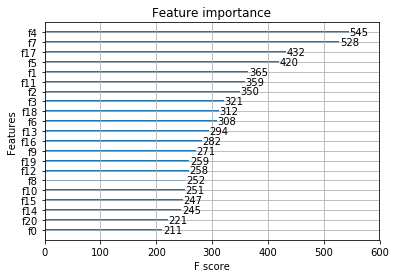

In [40]:
xgb.plot_importance(GBDT)

(array([9558.,  353.,  210.,  135.,  104.,   79.,   77.,   64.,   52.,
          49.,   33.,   39.,   29.,   34.,   17.,   11.,   21.,   23.,
          25.,   82.]),
 array([4.4368323e-15, 5.0000001e-02, 1.0000000e-01, 1.5000001e-01,
        2.0000000e-01, 2.5000000e-01, 3.0000001e-01, 3.4999999e-01,
        4.0000001e-01, 4.4999999e-01, 5.0000000e-01, 5.5000001e-01,
        6.0000002e-01, 6.4999998e-01, 6.9999999e-01, 7.5000000e-01,
        8.0000001e-01, 8.5000002e-01, 8.9999998e-01, 9.4999999e-01,
        1.0000000e+00], dtype=float32),
 <a list of 20 Patch objects>)

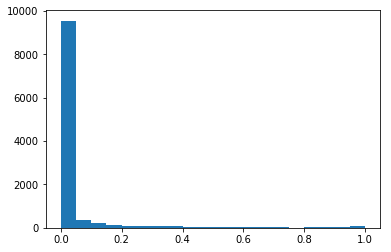

In [42]:
SignalScore=GBDT.predict(BDTSignal)
#plt.hist(SignalScore,bins=20)
BackgroundScore=GBDT.predict(BDTBackground)
plt.hist(BackgroundScore,bins=20)

(array([1.31300e+03, 3.05000e+02, 2.47000e+02, 2.11000e+02, 1.94000e+02,
        1.97000e+02, 2.04000e+02, 2.19000e+02, 2.23000e+02, 2.38000e+02,
        2.53000e+02, 2.78000e+02, 3.55000e+02, 3.98000e+02, 4.13000e+02,
        5.39000e+02, 6.87000e+02, 9.73000e+02, 1.89000e+03, 2.08111e+05]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <a list of 20 Patch objects>)

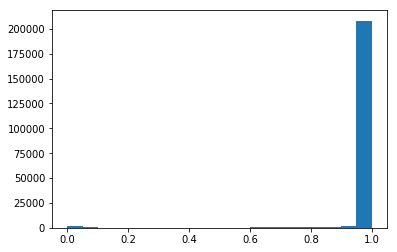

In [43]:
plt.hist(SignalScore,bins=20)

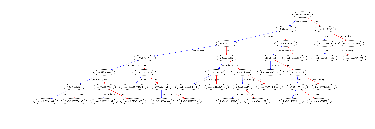

In [44]:
plot_tree(GBDT, num_trees=4)

(array([  9766.,    599.,    405.,    317.,    264.,    246.,    255.,
           252.,    244.,    256.,    265.,    284.,    345.,    386.,
           391.,    493.,    638.,    900.,   1717., 187395.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <a list of 20 Patch objects>)

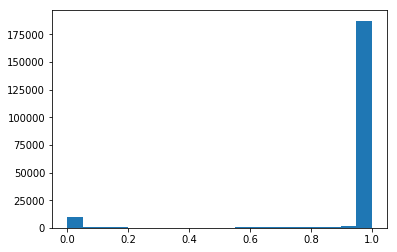

In [45]:
trainScore=GBDT.predict(BDTtrain)
plt.hist(trainScore,bins=20)

In [46]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,trainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)

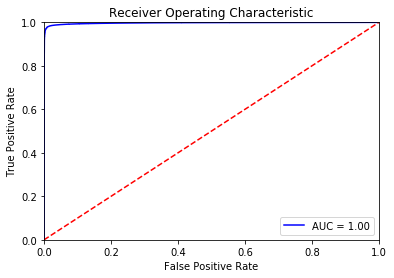

In [47]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,NNTrainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
pickle.dump(GBDT, open("GBDT_vbszz.pickle.dat", "wb"))